In [1]:
from metro_utils import (graph, extract_stations, pairs2rails, simulated_annealing,
                         subsets, total_distance, gen_distance_matrix, graph_x, initialise)
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from tqdm import tqdm
import networkx as nx
from networkx import from_numpy_matrix

if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "barcelona_reference"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [82]:
M = 1e10

def edge_sum(stations, x):
    connections = x.sum(axis=2)
    dist = gen_distance_matrix(city)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    return G.size('weight')

def cost(city, x):
    stations = city.stations
    connections = 1 * (x.sum(axis=2) > 0)
    dist = gen_distance_matrix(city)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for i, paths in all_paths:
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        # Get its kind
        for j, path in paths.items():
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                rails = [stations[i] for i in path]
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(rails))

        station_dists.append(sum(distances.values()))
        
    # Sum of min distances + sum of graph edge weight
    return sum(station_dists) + edge_sum(stations, x) / M

def total_distance_transfer_costs(path, dists, debug=False):      
    dist = 0
    i = path[0]
    for j in path[1:]:
        if debug:
            print('Step', dists[i, j])
        dist += dists[i, j]
        i = j
            
    return dist

def cost_transfer(city, x):
    stations = city.stations
    N = x.shape[0]
    K = x.shape[2]

    dist = gen_distance_matrix(city)
    final_dists = np.zeros((N*K, N*K))
    
    total_line_lengths = 0
    
    for k in range(K):
        # Intra line (Real Distance Costs)
        line_length = (x[:, :, k]*dist).sum() / 2
        total_line_lengths += line_length
        final_dists[N*k:N*(k+1), N*k:N*(k+1)] = x[:, :, k] * dist * 2*line_length
    
    average_wait_time = 2*total_line_lengths/K
    
    for k1 in range(K):
        for k2 in range(k1, K):
            if k1 != k2:
                # Inter line (Artificial Transfer Costs)
                s1s = x[:, :, k1].sum(axis=0).astype(int)
                s2s = x[:, :, k2].sum(axis=0).astype(int)
                shared = (s1s != 0) & (s2s != 0)
                shared_is = np.argwhere(shared > 0).reshape(-1,)
                final_dists[N*k1+shared_is, N*k2+shared_is] = average_wait_time
                final_dists[N*k2+shared_is, N*k1+shared_is] = average_wait_time
    
    G = from_numpy_matrix(final_dists)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    idx2station = lambda i: city.get_station(i % N)

    for i in range(N):
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        paths = [(end%N, path) for k in range(K) for (end, path) in all_paths[N*k + i][1].items()]

        # Get its kind
        for j, path in paths:
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                #if start == stations[3] and end == stations[4]:
                    #print(start.kind, end.kind)
                    #print(path, total_distance_transfer_costs(path, final_dists, debug=True))
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance_transfer_costs(path, final_dists))

        station_dists.append(sum(distances.values()))
        
    # Sum of min distances + sum of graph edge weight
    return sum(station_dists) + edge_sum(stations, x) / M

In [83]:
#city = City(locations=[(0, 0), (0.02, 0), (0.04, 0)], kinds=['square', 'circle', 'triangle'])

# 1 instance of unusual kinds
# Probability of kinds 

In [18]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city, K=2, cost_fn=cost)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.53s/it]

949.2647618037054


74.15149165675182 10.13732106143464


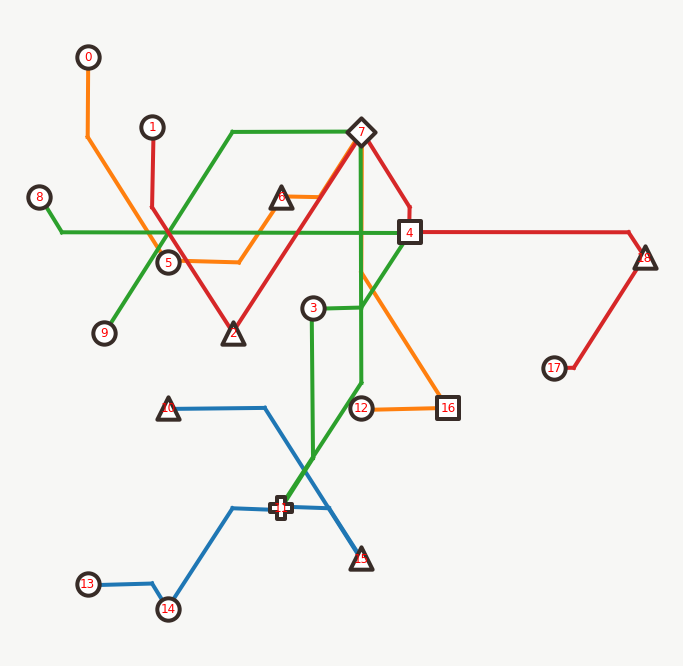

In [19]:
print(cost(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

In [35]:
x1 = np.array([
[[0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 1, 0]]
]).transpose(2, 1, 0)

x2 = np.array([
[[0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0]]
]).transpose(2, 1, 0)

In [44]:
print(cost(city, x1), cost_transfer(city, x1), edge_sum(city.stations, x1))

graph_x(city.stations, x1)

ValueError: operands could not be broadcast together with shapes (6,6) (19,19) 

In [8]:
print(cost(city, x2), cost_transfer(city, x2), edge_sum(city.stations, x2))

graph_x(city.stations, x2)

ValueError: operands could not be broadcast together with shapes (6,6) (19,19) 

# Include Transition Costs

In [113]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city, K=4, cost_fn=cost_transfer, max_iter=2500)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

 10%|████████▎                                                                          | 1/10 [00:32<04:53, 32.59s/it]

488.3812379679608


 20%|████████████████▌                                                                  | 2/10 [01:06<04:26, 33.32s/it]

445.7123961545115


 30%|████████████████████████▉                                                          | 3/10 [01:41<03:59, 34.26s/it]

393.1832660037494


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:32<00:00, 33.25s/it]


In [114]:
# Get the connections
connxns_sdvrp = {0: [(9,8),(8,0),(0,1)],
1: [(0,1),(1,5),(5,9),(9,10),(10,2),(2,3),(3,12),(12,16),(16,17),(17,18)],
2: [(13,14),(14,11),(11,15),(15,12)],
3: [(3,6),(6,7),(7,4)]
}

connxns_human = {0: [(0,1),(1,2),(2,3),(3,4),(4,16)],
                1: [(8,9),(9,10),(10,11),(11,12),(12,16)],
                2: [(13,14),(14,15),(15,16),(16,17),(17,18)],
                3: [(5,6),(6,7),(7,16)]}

def get_x(connxns):
    adj_matrices = []
    for c in connxns:
        adj_matrices.append([[1 if (i,j) in connxns[c] or (j,i) in connxns[c] else 0 for i in range(19)] for j in range(19)])
    return np.array(adj_matrices).transpose(2,1,0)

x3 = get_x(connxns_sdvrp)
x4 = get_x(connxns_human)

434.99365448942 5.943401871576773


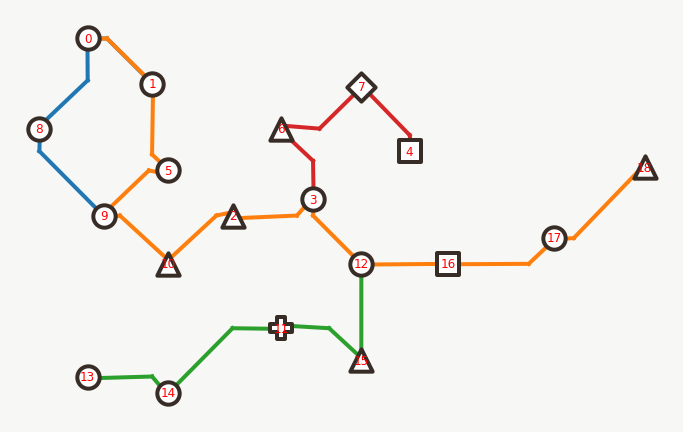

In [116]:
tensor = x3
print(cost_transfer(city, tensor), edge_sum(city.stations, tensor))
graph_x(city.stations, tensor, jitter=2, equal_aspect=True)

940.3835767754507 10.892295808265224


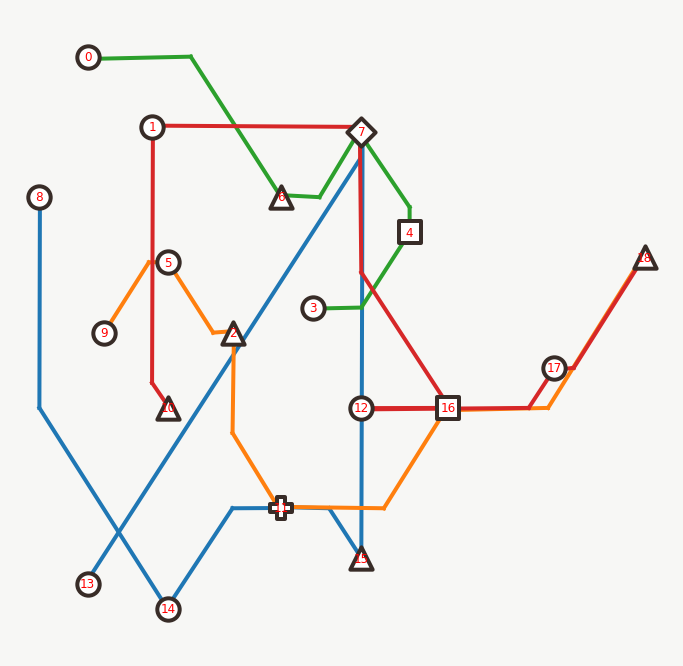

In [49]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

In [199]:
city = City(locations=[(0, 0), (0.02, 0), (0.04, 0)], kinds=['square', 'circle', 'triangle'])

# 1 instance of unusual kinds
# Probability of kinds 

In [200]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city, K=2, cost_fn=cost_transfer, max_iter=1000)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.91it/s]

0.4800008


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.93it/s]


0.4800008 0.08


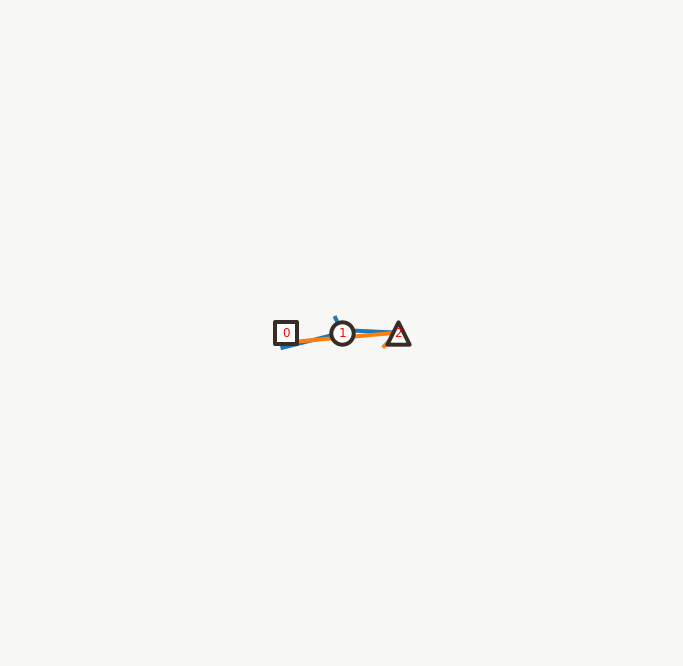

In [201]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

In [202]:
if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "cross"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [203]:
best_x, best_cost = None, 100*M
for restart in tqdm(range(15)):
    res_x, res_cost = simulated_annealing(city, K=2, cost_fn=cost_transfer, max_iter=1000)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

  7%|█████▌                                                                             | 1/15 [00:01<00:16,  1.21s/it]

437.3662730467707


 13%|███████████                                                                        | 2/15 [00:02<00:16,  1.29s/it]

433.2690692543927


 20%|████████████████▌                                                                  | 3/15 [00:03<00:15,  1.28s/it]

331.7187345300268


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:11<00:07,  1.22s/it]

280.357000288042


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.26s/it]


280.357000288042 5.692001435749995


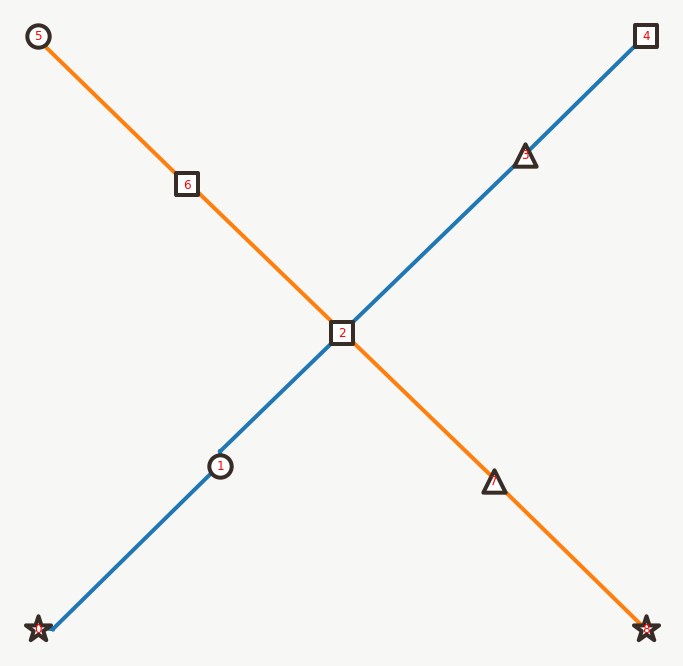

In [204]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

307.22588048306994 5.6920014357499955


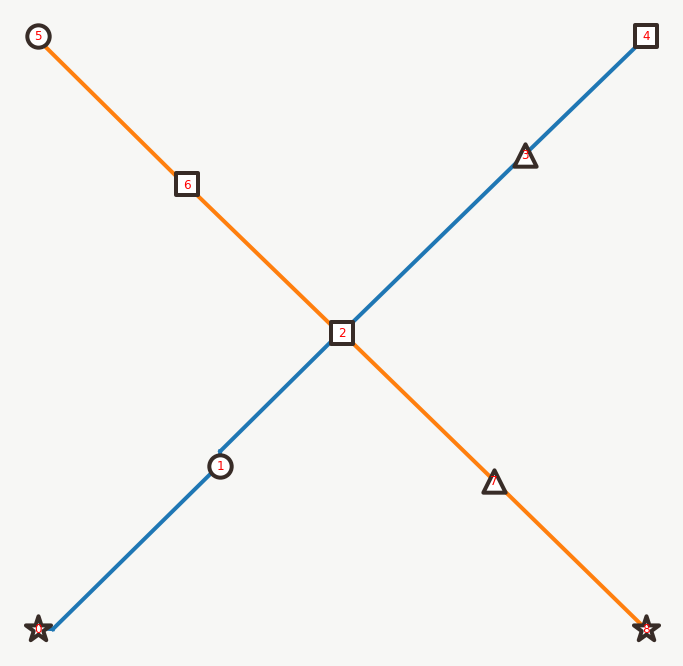

In [205]:
x1 = np.array([
[[0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]],
[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0]]
]).transpose(2, 1, 0)

print(cost_transfer(city, x1), edge_sum(city.stations, x1))

graph_x(city.stations, x1, jitter=1)

In [207]:
if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "dispersed"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [208]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city, K=2, cost_fn=cost_transfer, max_iter=1000)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

 10%|████████▎                                                                          | 1/10 [00:01<00:13,  1.48s/it]

312.8616069615553


 20%|████████████████▌                                                                  | 2/10 [00:02<00:11,  1.47s/it]

303.69488350701005


 40%|█████████████████████████████████▏                                                 | 4/10 [00:05<00:08,  1.43s/it]

293.06313768031714


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.47s/it]

273.1943251886574


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


273.1943251886574 5.122274887854692


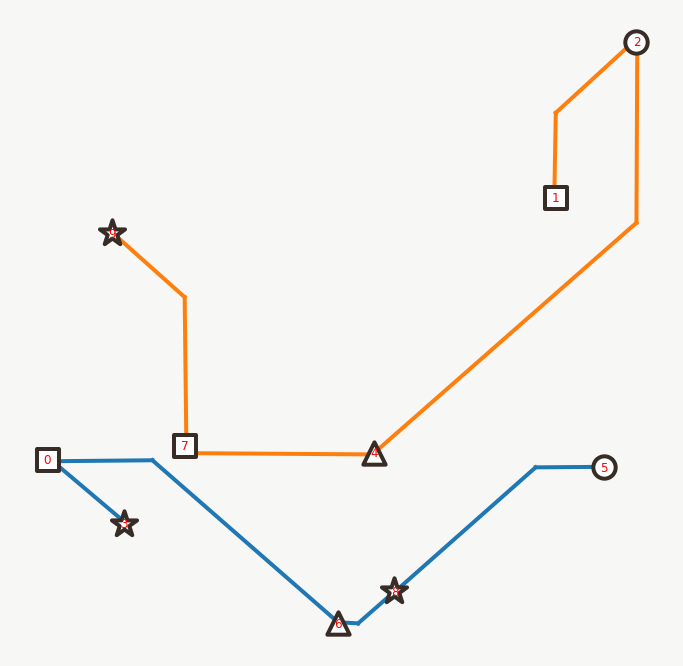

In [210]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

273.1943251886574 5.122274887854692


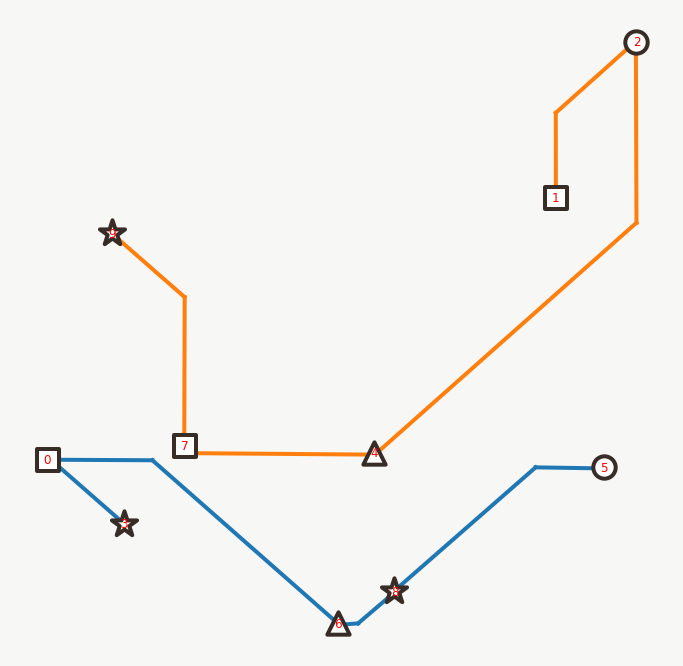

In [211]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

In [231]:
if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "4_cluster"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [236]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city, K=4, cost_fn=cost_transfer, max_iter=10_000, cutoff_val=0.001)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

 10%|████████▎                                                                          | 1/10 [00:49<07:29, 49.95s/it]

99.48746473382337


 20%|████████████████▌                                                                  | 2/10 [01:42<06:52, 51.58s/it]

93.97545346763224


 30%|████████████████████████▉                                                          | 3/10 [02:33<05:59, 51.30s/it]

87.56399382053773


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:16<04:17, 51.44s/it]

81.26988512975775


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:47<00:00, 52.74s/it]


81.26988512975775 3.251570993473475


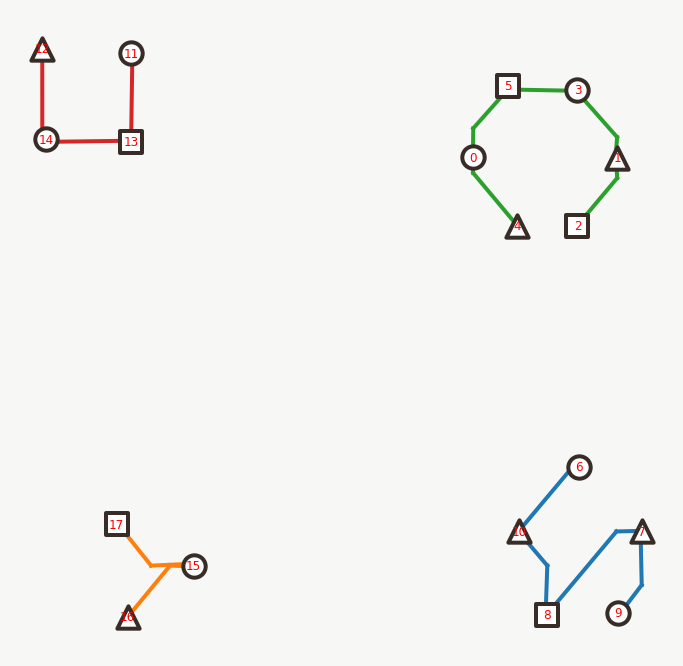

In [237]:
print(cost_transfer(city, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x, jitter=1)

In [3]:
if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "4_cluster"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [19]:
best_x, best_cost, final_cur_xs, final_new_xs = None, M, None, None
for restart in tqdm(range(10)):
    res_x, res_cost, cur_xs, new_xs = simulated_annealing(city, K=4, cost_fn=cost_transfer, max_iter=25_000, 
                                                          cutoff_val=0.001, save=True)
    if res_cost < best_cost:
        best_x, best_cost, final_cur_xs, final_new_xs = res_x, res_cost, cur_xs, new_xs
        print(best_cost)

 10%|████████▏                                                                         | 1/10 [02:02<18:26, 122.98s/it]

96.50404697284642


 20%|████████████████▍                                                                 | 2/10 [04:04<16:16, 122.02s/it]

88.48858206207626


 30%|████████████████████████▌                                                         | 3/10 [06:06<14:15, 122.20s/it]

83.26571153550438


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:50<00:00, 125.07s/it]


In [28]:
for i, x in enumerate(final_new_xs):
    if (x == best_x).all():
        print(i)
        break

20727


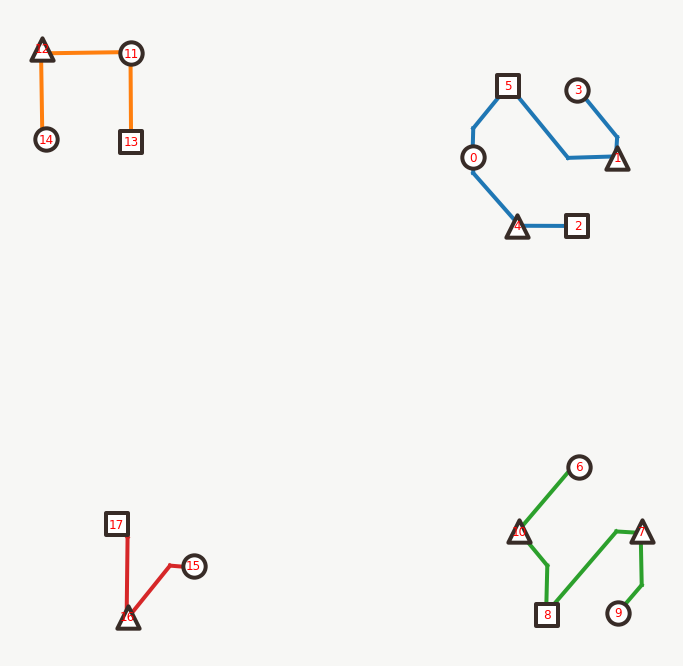

In [20]:
graph_x(city.stations, best_x, jitter=1)

In [78]:
import pandas as pd

if 0:
    costs = [cost_transfer(city, x) for x in xs] + [best_cost]

    pd.DataFrame(costs).to_csv('costs.csv')

In [104]:
all_costs = [cost_transfer(city, x) for x in final_new_xs]

In [105]:
from __future__ import annotations
import numpy as np
from itertools import permutations, chain, combinations  
from math import ceil
from station import Station
from city import City
import matplotlib.pyplot as plt
from numpy.random import shuffle, randint, choice
from copy import deepcopy
from time import time

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes
HORIZONTAL, VERTICAL = 0, 1

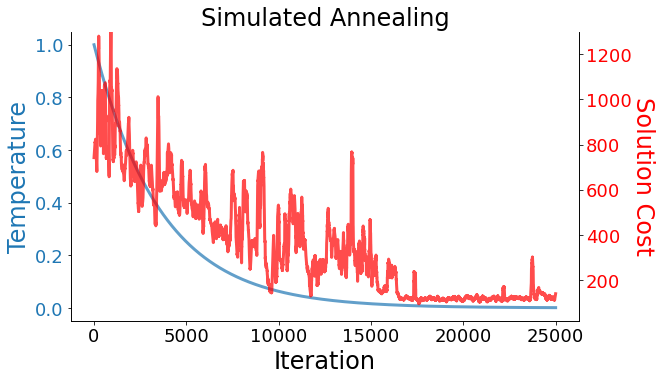

In [134]:
if 0:
    from scipy.signal import savgol_filter
    yy = savgol_filter(all_costs, 101, 1)

    xx = np.arange(len(all_costs))

    def T(t):
        return np.exp(np.log(0.001)*t / 25_000)

    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax1 = ax2.twinx()
    ax2.set_title('Simulated Annealing')
    ax2.set_xlabel('Iteration')
    c1, c2 = 'red', 'C0'

    ax1.plot(xx, yy, c=c1, lw=LW, alpha=0.7)
    #ax1.yaxis.offsetText.set_fontsize(SMALL)
    ax1.spines['top'].set_color('none')
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.tick_params(axis='both', which='major')
    ax1.set_ylabel('Solution Cost', c=c1, rotation=270)
    ax1.yaxis.set_label_coords(1.15, 0.5)
    ax1.set_ylim(20, 1_300)
    #ax1.set_yscale('log')

    ax2.plot(xx, T(xx), c=c2, lw=LW, alpha=0.7)
    #ax2.yaxis.offsetText.set_fontsize(SMALL)
    ax2.spines['top'].set_color('none')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax2.tick_params(axis='both', which='major')
    ax2.set_ylabel('Temperature', c=c2)

    plt.tight_layout()
    plt.savefig('simulated_annealing.png')
    plt.show()

In [31]:
if 0:
    filenames = []

    xs = final_new_xs[:20727+1:50]
    for i, x in tqdm(enumerate(xs), total=len(xs)):
        filename = f'4_cluster{i:0>7}'
        filenames.append(filename)
        graph_x(city.stations, x, jitter=1, filename=filename, show_station_ids=False)


    filename = f'4_cluster{i+1:0>7}'
    filenames.append(filename)
    graph_x(city.stations, best_x, jitter=1, filename=filename, show_station_ids=False)

100%|████████████████████████████████████████████████████████████████████████████████| 415/415 [02:25<00:00,  2.85it/s]


In [ ]:
%%time
if 0:
    import imageio

    with imageio.get_writer('4_cluster.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(f'images/{filename}.png')
            writer.append_data(image)
        for _ in range(40):
            image = imageio.imread(f'images/{filename}.png')
            writer.append_data(image)

In [101]:
if 0:
    import matplotlib.image as mpimg

    cM, cm = 1_000, min(costs)
    m, M = 140, 730

    def f(y):
        if y > cM:
            y = cM

        p = (y - cm) / (cM - cm)

        return M - p * (M - m)
    
    def T(t):
        return np.exp(np.log(0.001)*50*t / 20727)

    for i, (filename, cost) in tqdm(list(enumerate(zip(filenames, costs)))):
        fig, ax = plt.subplots(figsize=(24, 24))

        ax.axis('off')

        ax.plot([780, 820], 2*[f(cost)], c='red', lw=5, label='Solution Cost', zorder=20)
        ax.plot([780, 820], 2*[f(T(i) * (cM - cm) + cm)], c='C0', lw=5, zorder=10, label='Temperature')
        ax.plot([780, 820], 2*[f(cm)], c='black', lw=5)
        ax.plot([780, 820], 2*[f(cM)], c='black', lw=5)

        img = mpimg.imread(f'images/{filename}.png')
        imgplot = plt.imshow(img)

        ax.legend(loc='upper center', ncol=2, frameon=False, fontsize=40, bbox_to_anchor=[0.53, 0.92])
        
        plt.savefig('final/' + filename + '.png', facecolor='white', transparent=False, dpi=fig.dpi)
        plt.close()

        #plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 416/416 [04:12<00:00,  1.65it/s]


In [103]:
%%time
if 0:
    import imageio

    with imageio.get_writer('4_cluster_final.gif', mode='I') as writer:
        for filename in tqdm(filenames):
            image = imageio.imread(f'final/{filename}.png')
            writer.append_data(image)
        for _ in range(40):
            image = imageio.imread(f'final/{filename}.png')
            writer.append_data(image)

CPU times: total: 2min 22s
Wall time: 2min 26s


# Computational Study

In [ ]:
def simulated_annealing(city, K, cost_fn, max_iter=100, cutoff_val=0.001, save=False, experiment_max_iters=[]):
    ''' Performs simulated annealing to find (try and find) the optimal configuration 
        K is number of lines '''
    # Initialise Configuration
    cur_x = initialise(len(city.stations), K)
    cur_cost = cost_fn(city, cur_x)
    best_x, best_cost = cur_x, cur_cost
    
    experiment_max_iters = set(experiment_max_iters)
    
    # Time
    t = 0
    
    cur_xs = []
    new_xs = []
    costs = []
    
    while True:
        if save:
            cur_xs.append(cur_x)
        
        # Update current temperature
        T = np.exp(np.log(cutoff_val)*t / max_iter)
        
        if t in experiment_max_iters:
            costs.append(best_cost)
            
        # End of simulated annealing
        if T < cutoff_val:
            if experiment_max_iters:
                return costs
            if save:
                return best_x, best_cost, cur_xs, new_xs
            # Return configuration and its value
            return best_x, best_cost
        
        # Make random change
        new_x = get_neighbour(cur_x)
        new_cost = cost_fn(city, new_x)
        
        if save:
            new_xs.append(new_x)
        
        # Keep change if it is an improvement (or randomly sometimes)
        if new_cost < cur_cost or np.random.uniform(0, 1) < T:
            cur_x, cur_cost = new_x, new_cost
            
            if cur_cost < best_cost:
                best_x, best_cost = cur_x, cur_cost
            
        t += 1

In [ ]:
from time import time
from itertools import product

n_trials = 3
max_iters = [100, 250, 500, 1_000, 2_500, 5_000, 10_000]
cutoff_vals = [0.0001, 0.001, 0.01, 0.1]

# Store results
res_n_stations = []
res_max_iter__ = []
res_cutoff_val = []

res_time_taken = []
res_soltn_cost = []

hyper_params = list(product(range(n_trials), range(2, 10)))

for trial, n_stations in tqdm(hyper_params):
    city = City(n_stations=n_stations)
    for cutoff_val in cutoff_vals:
        t0 = time()
        soltn_costs, t1s = simulated_annealing(city, K=2, cost_fn=cost_transfer, max_iter=max(max_iters), 
                                               cutoff_val=cutoff_val, experiment_max_iters=max_iters)

        for max_iter, soltn_cost, t1 in zip(max_iters, soltn_costs, t1s)
        
            res_n_stations.append(n_stations)
            res_max_iter__.append(max_iter  )
            res_cutoff_val.append(cutoff_val)
            res_time_taken.append(t1 - t0   )
            res_soltn_cost.append(soltn_cost)